# Graph Neural Networks (GNNs)

### Importing libraries and getting started

In [1]:
%matplotlib inline
try:
    import torch
    from torch_geometric.datasets import MoleculeNet
    from torch_geometric.loader import DataLoader
    from rdkit import Chem
    from utils.graph import GenFeatures, seed_everything, EarlyStopping
    from torch_geometric.nn.models import AttentiveFP
    import torch.nn.functional as F
    from math import sqrt
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError:
    !pip install torch
    !pip install rdkit
    !pip install torch_geometric
    !pip install sklearn
    !pip install matplotlib
    !pip install seaborn
    

Many datasets are available as open access, in this tutorial we work with the (ESOL - Estimated SOLubility) dataset by [Delaney 2014](https://pubs.acs.org/doi/10.1021/ci034243x). The data has been heavily used for benchmarking QSPRs (Quantitative Structure-Property Relations). All data are experimental and describe the logarithm of the solubility of organic compounds in water in mol/L.

In [2]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
# define path
path = 'data/'
#set seed for reproducibility
seed_everything(45)

# load the data
dataset = MoleculeNet(path, name='ESOL', pre_transform=GenFeatures()).shuffle()

print("ESOL is a dataset of N={} measured solubility of organic compounds in water. The solubility is expressed in terms of logWs and the solubility is expressed in mol/L. The featurization process produces node and edge features of {} atom features and {} bond features".format(
dataset.data.y.shape[0], dataset.data.x.shape[1], dataset.data.edge_attr.shape[1]))

ESOL is a dataset of N=1128 measured solubility of organic compounds in water. The solubility is expressed in terms of logWs and the solubility is expressed in mol/L. The featurization process produces node and edge features of 39 atom features and 10 bond features


C:\Users\arnaou\AppData\Local\miniconda3\envs\qspr\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


### Graph Neural Networks - intuitive approach for QSPR modelling

Formally, a graph *G(v,e)* is composed of a set of vertices/nodes *v* linked with a set of edges *e*. This is very much in resemblance with how molecules are depicted using the ball-and-stick representation as seen below for the caffeine molecule (figure courtesy of [Adem R.N. Aouichaoui](https://github.com/arnaou/arnaou)).

![Molecular graphs](img/graph_mol.png)

A graph neural network (GNN) is a special type of neural network that operates on graph data. GNNs can be used for node prediction, edge prediction and graph prediction. For the purpose of this tutorial, we only consider graph-level prediction e.i. predict something related to the graph as whole, in this case, the property.

The GNN operates on a graph through what is called the "*message-passing framework*". This framework consists of three main operations:
* Message construction: neighbouring nodes/edges combine their hidden representation to produce a message
* Node/edge update: the message is then used to update the hidden representation of the node/edge
* Graph-to-vector transformation: after sufficient iterations of the above-mentioned steps, the graph representation is converted into a vector representation. This operation is also known as the readout.

The output of the readout is used as input to a feedforward neural network also known as multi-layer perceptron - MLP.

The process is illustrated below (figure courtesy of [Adem R.N. Aouichaoui](https://github.com/arnaou/arnaou)).

![GNN framework](img/gnn_framework.png)


the hidden features of the nodes and edges reflect the molecular structural information, which are necessary for the given application (molecular property prediction). As mentioned earlier, 39 atom features and 10 bond features were used. These were selected in accordance to previous studies:
* [Pushing the Boundaries of Molecular Representation for Drug Discovery with the Graph Attention Mechanism](https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959)
* [Combining Group-Contribution Concept and Graph Neural Networks Toward Interpretable Molecular Property Models](https://pubs.acs.org/doi/full/10.1021/acs.jcim.2c01091)
* [Application of interpretable group-embedded graph neural networks for pure compound properties](https://www.sciencedirect.com/science/article/pii/S0098135423001618)

These features are summarized below:

| **atom feature**  	| **size** 	| **description**                                                       	|
|-------------------	|----------	|-----------------------------------------------------------------------	|
| atom type         	| 16       	| [B, C, N, O, F, Si, P, S, Cl, As, Se, Br, Te, I, At, metal] (one-hot) 	|
| degree            	| 6        	| number of covalent bonds [0,1,2,3,4,5] (one-hot)                      	|
| formal charge     	| 1        	| electrical charge (integer)                                           	|
| radical electrons 	| 1        	| number of radical electrons (integer)                                 	|
| hybridization     	| 6        	| [sp, sp2, sp3, sp3d, sp3d2, other] (one-hot)                          	|
| aromaticity       	| 1        	| whether the atom is part of an aromatic system [0/1] (one-hot)        	|
| hydrogens         	| 5        	| number of connected hydrogens [0,1,2,3,4] (one-hot)                   	|
| chirality         	| 1        	| whether the atom is chiral center [0/1] (one-hot)                     	|
| chirality type    	| 2        	| [R, S] (one-hot)                                                      	|


| **bond feature**  	| **size** 	| **description**                                                       	|
|-------------------	|----------	|-----------------------------------------------------------------------	|
| bond type         	| 4        	| [single, double, triple, aromatic] (one-hot)                          	|
| conjugation       	| 1        	| whether the bond is conjugated [0/1] (one-hot)                        	|
| ring              	| 1        	| whether the bond is in ring [0/1] (one-hot)                           	|
| stereo            	| 4        	| [StereoNone, StereoAny, StereoZ, StereoE] (one-hot)                   	|


### Preprocessing

The data are split into three folds for: i) training, ii) validation and iii) testing.

The ratios chosen here are arbitrary and the split is (in principle) random (see the shuffle command when loading the data)

In [4]:
N = len(dataset) // 10
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]

The outputs are scaled using z-score scaling

In [5]:
# calculate scaling parameters
mu = train_dataset.data.y.mean()
sigma = train_dataset.data.y.std()

# scale the data
train_dataset.data.y = (train_dataset.data.y-mu)/sigma
val_dataset.data.y = (val_dataset.data.y-mu)/sigma
test_dataset.data.y = (test_dataset.data.y-mu)/sigma

We use the dataloaders to pack the data and make the iterable for the training and batching. The batch size is set to the size of the dataset in order to obtain the true gradient

In [6]:
# implement dataloader for the data
train_loader = DataLoader(train_dataset, batch_size=train_dataset.data.y.shape[0], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=val_dataset.data.y.shape[0])
test_loader = DataLoader(test_dataset, batch_size=test_dataset.data.y.shape[0])

The training can be GPU enabled as follows

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Model definition and model training

In this tutorial, we will train the *attentiveFP* developed by [Xiong et al. 2021](https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959). More details can be found the provided reference or at the [PyG documentation](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/attentive_fp.html)

In [8]:
# defining model
model = AttentiveFP(in_channels=dataset.data.x.shape[1], hidden_channels=111, out_channels=dataset.data.y.shape[1],
                    edge_dim=dataset.data.edge_attr.shape[1], num_layers=2, num_timesteps=2,
                    dropout=0.0).to(device)

We then set up the training. In this training we use some advanced tools that are explained in the following:
* early stopping: a regularization technique that ensure the model with the lowest validation score is saved and reloaded in case the error increases (overfitting). The patience, is the number of epochs to wait before terminating the training.
* learning rate scheduler: in case the learning stagnates, the learning rate is decreased to squeeze the last learnings out. it refines the learning.

In [9]:
# define the optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=10**-2.5,
                             weight_decay=10**-5)


# define the no_epochs
no_epochs = 250

# initialize list for the errors
train_loss = []
test_loss = []
val_loss = []

# initialize the early_stopping object
patience = 20
early_stopping = EarlyStopping(patience=patience, verbose=True)

# define a learning rate scheduler to squeeze the last out of the training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience//3, factor=0.75 )

# train loop
for epoch in range(1, no_epochs):
    total_loss = total_examples = 0
    # train cycle
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss= F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
        train_rmse = sqrt(total_loss / total_examples)
    train_loss.append(float(train_rmse))
        
    with torch.no_grad():
        # validation cycle
        total_loss = total_examples = 0
        for data in val_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = F.mse_loss(out, data.y)
            total_loss += float(loss) * data.num_graphs
            total_examples += data.num_graphs
            val_rmse = sqrt(total_loss / total_examples)
        val_loss.append(float(val_rmse))
        # test cycle    
        total_loss = total_examples = 0
        for data in test_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = F.mse_loss(out, data.y)
            total_loss += float(loss) * data.num_graphs
            total_examples += data.num_graphs
            test_rmse = sqrt(total_loss / total_examples)
        test_loss.append(float(test_rmse))
    # early_stopping needs the validation loss to check if it has decreased, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(val_rmse, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    # reduce learning rate
    scheduler.step(val_rmse)
    
    print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
      f'Test: {test_rmse:.4f}')

# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))
        

Validation loss decreased (inf --> 1.442582).  Saving model ...
Epoch: 001, Loss: 2.0616 Val: 1.4426 Test: 1.4460
EarlyStopping counter: 1 out of 20
Epoch: 002, Loss: 1.4221 Val: 1.6006 Test: 1.2207
Validation loss decreased (1.442582 --> 1.191518).  Saving model ...
Epoch: 003, Loss: 1.2999 Val: 1.1915 Test: 0.9870
Validation loss decreased (1.191518 --> 0.952641).  Saving model ...
Epoch: 004, Loss: 1.0209 Val: 0.9526 Test: 0.8702
Validation loss decreased (0.952641 --> 0.824240).  Saving model ...
Epoch: 005, Loss: 0.8719 Val: 0.8242 Test: 0.7722
Validation loss decreased (0.824240 --> 0.695892).  Saving model ...
Epoch: 006, Loss: 0.7662 Val: 0.6959 Test: 0.6406
Validation loss decreased (0.695892 --> 0.584904).  Saving model ...
Epoch: 007, Loss: 0.6365 Val: 0.5849 Test: 0.5194
Validation loss decreased (0.584904 --> 0.490709).  Saving model ...
Epoch: 008, Loss: 0.5212 Val: 0.4907 Test: 0.4295
Validation loss decreased (0.490709 --> 0.379832).  Saving model ...
Epoch: 009, Loss: 

<All keys matched successfully>

### Model prediction and evaluation

we can inspect the trajectory of the model training by inspecting the learning curves. this is especially usefull to check whether there is any overfitting.

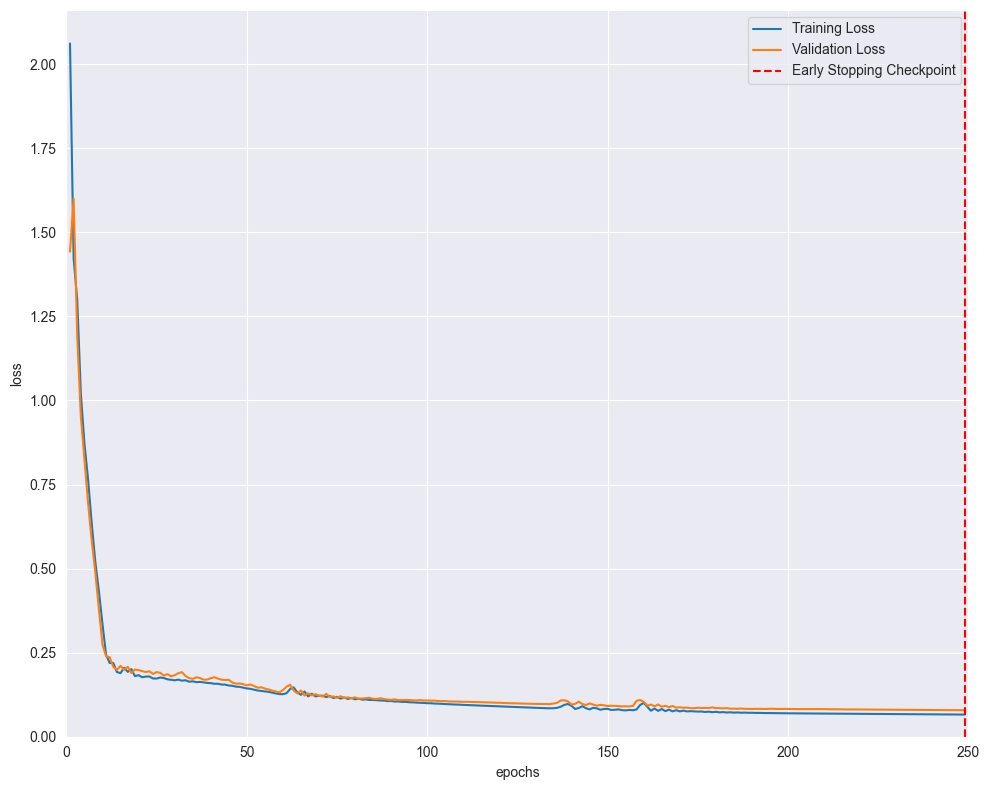

In [10]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = val_loss.index(min(val_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, ) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

now that training has finished, we can make predictions and calculate the error metrics as well as perform visualizations

In [11]:
# perform predictions
with torch.no_grad():
    counter = 0
    # prediction on training data
    for data in train_loader:
        if counter == 0:
            train_pred = model(data.x, data.edge_index, data.edge_attr, data.batch)  
            train_target = data.y
            counter += 1
        else:
           train_pred = torch.cat([train_pred, model(data.x, data.edge_index, data.edge_attr, data.batch)], dim=0)
           train_target =torch.cat(train_target, data.y)
    # prediction on validation data
    counter = 0
    for data in val_loader:
        if counter == 0:
            val_pred = model(data.x, data.edge_index, data.edge_attr, data.batch)  
            val_target = data.y
            counter += 1
        else:
           val_pred = torch.cat([val_pred, model(data.x, data.edge_index, data.edge_attr, data.batch)], dim=0)
           val_target =torch.cat(val_target, data.y)
    # prediction on test data
    counter = 0
    for data in test_loader:
        if counter == 0:
            test_pred = model(data.x, data.edge_index, data.edge_attr, data.batch)    
            test_target = data.y
            counter += 1
        else:
            test_pred = torch.cat([test_pred, model(data.x, data.edge_index, data.edge_attr, data.batch)], dim=0)    
            test_target =torch.cat(test_target, data.y)
# the predictions are rescaled  and converted into numpy arrays
train_pred = (train_pred*sigma + mu).numpy()
train_target = (train_target*sigma + mu).numpy()
val_pred = (val_pred*sigma + mu).numpy()
val_target = (val_target*sigma + mu).numpy()
test_pred = (test_pred*sigma + mu).numpy()
test_target = (test_target*sigma + mu).numpy()

Various performance metrics can then be calculated

In [12]:
# calculate R-squared values
r2_train = r2_score(train_target, train_pred)
r2_val = r2_score(val_target, val_pred)
r2_test = r2_score(test_target, test_pred)

# calculated mean absolute error
mae_train = mean_absolute_error(train_target, train_pred)
mae_val = mean_absolute_error(val_target, val_pred)
mae_test = mean_absolute_error(test_target, test_pred)

# calculate root mean squared error
rmse_train = sqrt(mean_squared_error(train_target, train_pred))
rmse_val = sqrt(mean_squared_error(val_target, val_pred))
rmse_test = sqrt(mean_squared_error(test_target, test_pred))


print("The trained model achieved a training rmse of {}, a validation rmse of {}, and a test rmse of {}".format(rmse_train, rmse_val, rmse_test))
print("The trained model achieved a training mae of {}, a validation mae of {}, and a test mae of {}".format(mae_train, mae_val, mae_test))
print("The trained model achieved a training R2 of {}, a validation R2 of {}, and a test R2 of {}".format(r2_train, r2_val, r2_test))


The trained model achieved a training rmse of 0.13794557000835247, a validation rmse of 0.16506893970988026, and a test rmse of 0.166847043231587
The trained model achieved a training mae of 0.10483476519584656, a validation mae of 0.11387008428573608, and a test mae of 0.12244278192520142
The trained model achieved a training R2 of 0.913867252767634, a validation R2 of 0.9017323208533927, and a test R2 of 0.8781822159354057


a parity plot is constructed to visualize the goodness of fit

Text(0, 0.5, 'Predicted solubility')

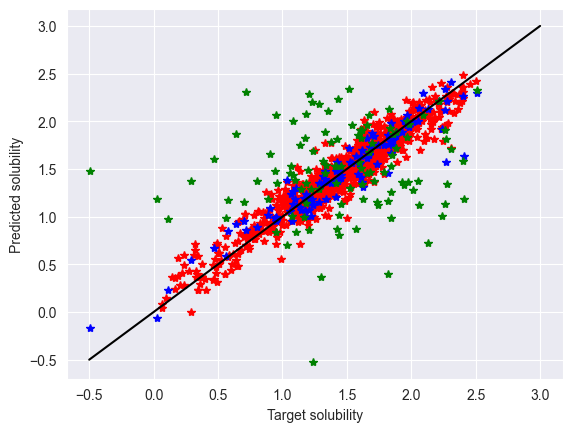

In [13]:
plt.plot(train_target, train_pred, "r*", label="train")
plt.plot(val_target, val_pred, "b*", label="val")
plt.plot(val_target, test_pred, "g*", label="test")
plt.plot([-0.5, 3],[-0.5, 3], "k-")
plt.xlabel("Target solubility")
plt.ylabel("Predicted solubility")

we can also plot the residuals

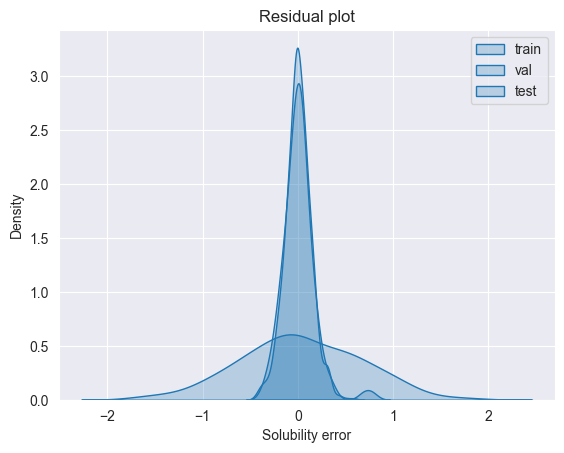

In [16]:
# calculate the residuals
res_train = train_target-train_pred
res_val = val_target-val_pred
res_test = test_target-val_pred

# plot distribution
sns.kdeplot(res_train, color='red', label='train', fill=True)
sns.kdeplot(res_val, color='blue', label='val', fill=True)
sns.kdeplot(res_test, color='green', label='test', fill=True)

# Add labels and title
plt.xlabel('Solubility error')
plt.ylabel('Density')
plt.title('Residual plot')

# Show legend
plt.legend()

# Show the plot
plt.show()

the obtained results are rather far from the SOTA obtained in studies such:
* [Pushing the Boundaries of Molecular Representation for Drug Discovery with the Graph Attention Mechanism](https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959)
* [Combining Group-Contribution Concept and Graph Neural Networks Toward Interpretable Molecular Property Models](https://pubs.acs.org/doi/full/10.1021/acs.jcim.2c01091)


This can be fixed by:
* using early stopping
* increasing the epoch number
* using a reduced learning rate
* changing the model hyperparameter

### Acknowledgments

the example is inspired by code available in the [PyG documentation](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/attentive_fp.py)

In [15]:
#TODO:
# learning curves
# reduced learning rate
# early stopping
# plot results